<a href="https://colab.research.google.com/github/ruscobby/final_project/blob/main/insurance_charges_charles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import QuantileTransformer
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import os



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Ironhack-final-project/insurance.csv")

In [ ]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [ ]:
df.shape

(1338, 7)

In [ ]:
print("=== Missing Values ===")
print(df.isnull().sum())
print("\n")

=== Missing Values ===
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64




In [ ]:
#Encode categorical variables
# 'sex', 'smoker', 'region' are categorical
df_encoded = df.copy()

In [ ]:
# Convert 'sex' and 'smoker' to binary
df_encoded['sex'] = df_encoded['sex'].map({'male': 1, 'female': 0})
df_encoded['smoker'] = df_encoded['smoker'].map({'yes': 1, 'no': 0})


In [ ]:
# One-hot encode 'region'
df_encoded = pd.get_dummies(df_encoded, columns=['region'], drop_first=True)


In [ ]:
print("=== Encoded Data Sample ===")
print(df_encoded.head())
print("\n")

=== Encoded Data Sample ===
   age  sex     bmi  children  smoker      charges  region_northwest  \
0   19    0  27.900         0       1  16884.92400             False   
1   18    1  33.770         1       0   1725.55230             False   
2   28    1  33.000         3       0   4449.46200             False   
3   33    1  22.705         0       0  21984.47061              True   
4   32    1  28.880         0       0   3866.85520              True   

   region_southeast  region_southwest  
0             False              True  
1              True             False  
2              True             False  
3             False             False  
4             False             False  




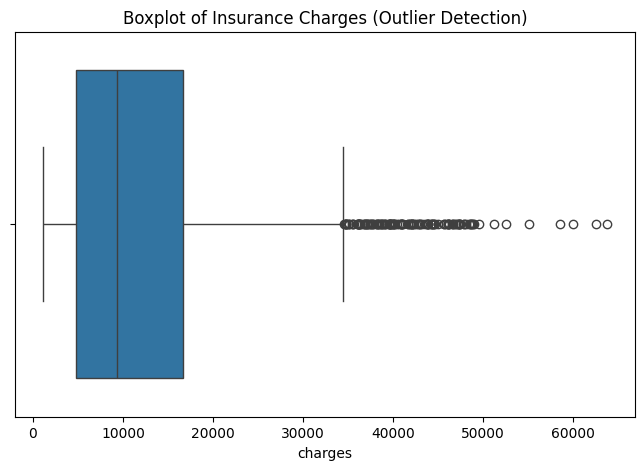

In [ ]:
#Inspect outliers for 'charges'
plt.figure(figsize=(8,5))
sns.boxplot(x=df_encoded['charges'])
plt.title("Boxplot of Insurance Charges (Outlier Detection)")
plt.show()

In [ ]:
#basic statistics to identify extreme values
print("=== Charges Statistics ===")
print(df_encoded['charges'].describe())

=== Charges Statistics ===
count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64


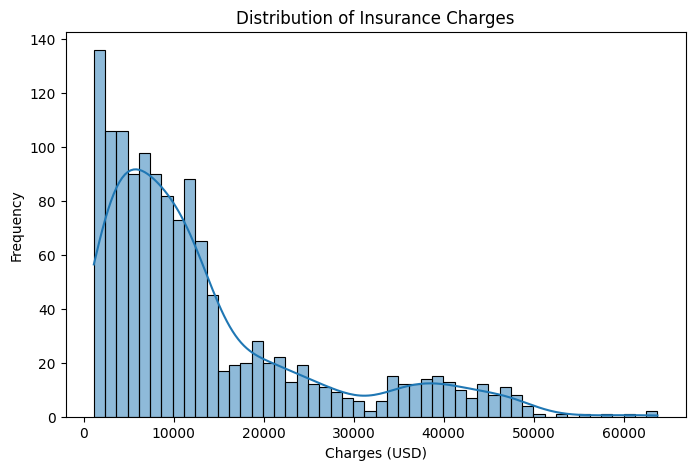

In [ ]:
#Distribution of charges
plt.figure(figsize=(8,5))
sns.histplot(df_encoded['charges'], bins=50, kde=True)
plt.title("Distribution of Insurance Charges")
plt.xlabel("Charges (USD)")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Check skewness
print("Skewness of Charges:", df_encoded['charges'].skew())
print("Kurtosis of Charges:", df_encoded['charges'].kurtosis())
print("\n")

Skewness of Charges: 1.5158796580240388
Kurtosis of Charges: 1.6062986532967907




In [ ]:
# Initialize transformer
qt = QuantileTransformer(
    output_distribution='normal',
    random_state=0
)

# Apply quantile transformation to charges
df['charges_qt'] = qt.fit_transform(
    df[['charges']]
).flatten()

# Check skewness
print(f"Skewness after Quantile Transformation: {df['charges_qt'].skew():.5f}")

Skewness after Quantile Transformation: 0.00207


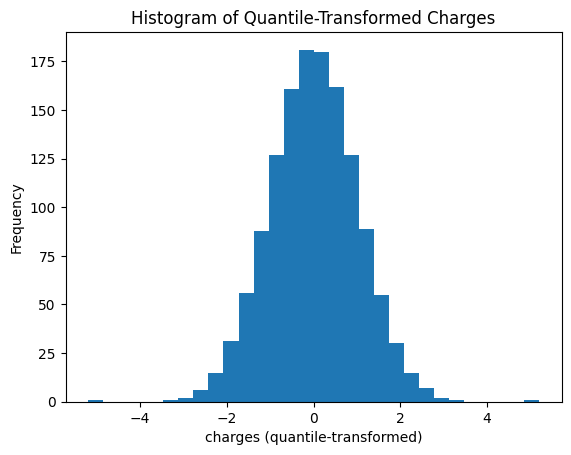

In [ ]:
# Histogram of quantile-transformed charges
plt.figure()
plt.hist(df['charges_qt'], bins=30)
plt.title('Histogram of Quantile-Transformed Charges')
plt.xlabel('charges (quantile-transformed)')
plt.ylabel('Frequency')
plt.show()

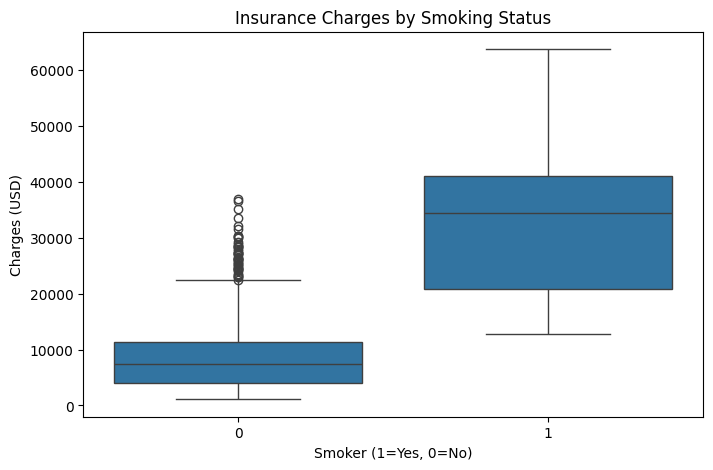

In [ ]:
#Boxplots by smoker
plt.figure(figsize=(8,5))
sns.boxplot(x='smoker', y='charges', data=df_encoded)
plt.title("Insurance Charges by Smoking Status")
plt.xlabel("Smoker (1=Yes, 0=No)")
plt.ylabel("Charges (USD)")
plt.show()

In [ ]:
#Boxplots by region (one-hot columns)
region_cols = [col for col in df_encoded.columns if 'region_' in col]

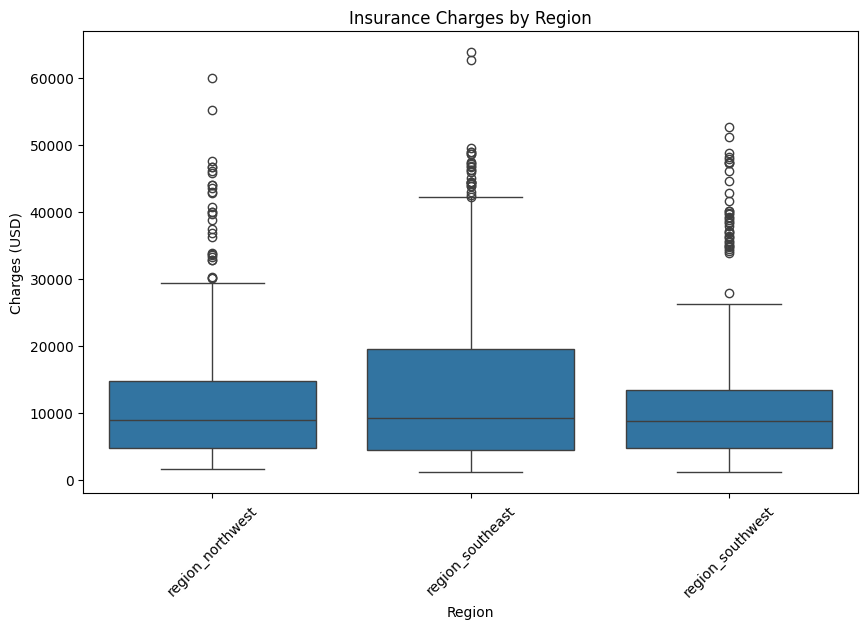

In [ ]:
#Melt dataframe for seaborn boxplot
df_melt = df_encoded.melt(id_vars='charges', value_vars=region_cols, var_name='region', value_name='present')
df_melt = df_melt[df_melt['present']==1]  # keep only rows where region is present

plt.figure(figsize=(10,6))
sns.boxplot(x='region', y='charges', data=df_melt)
plt.title("Insurance Charges by Region")
plt.xlabel("Region")
plt.ylabel("Charges (USD)")
plt.xticks(rotation=45)
plt.show()

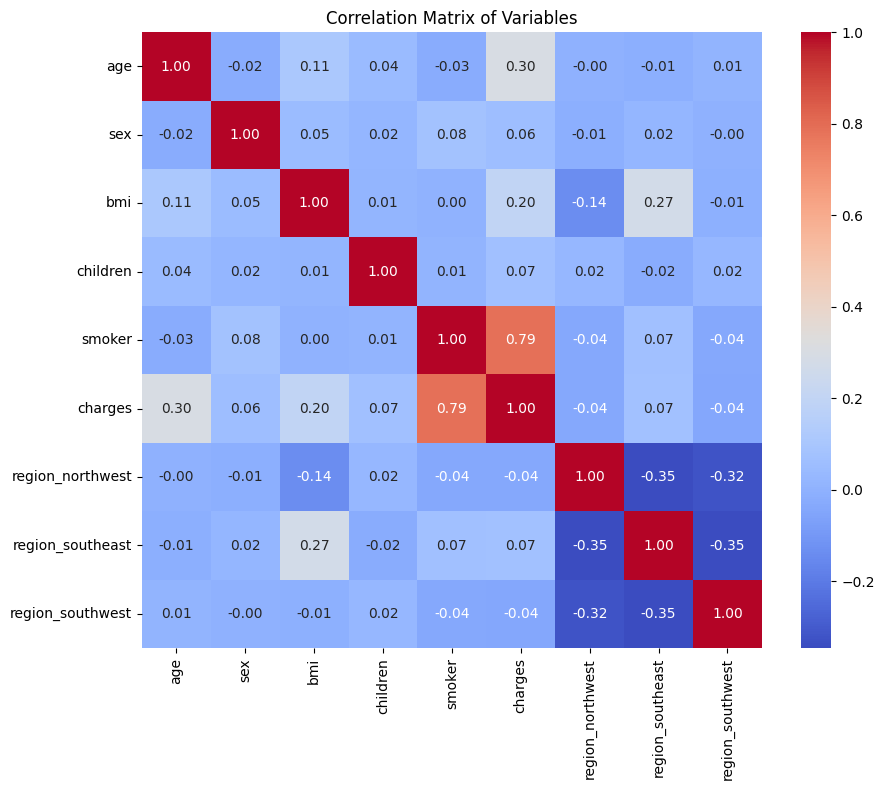

In [ ]:
#Correlation matrix
plt.figure(figsize=(10,8))
corr = df_encoded.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Matrix of Variables")
plt.show()

In [ ]:
#t-test: Smoker vs Non-Smoker
smoker_charges = df_encoded[df_encoded['smoker']==1]['charges']
nonsmoker_charges = df_encoded[df_encoded['smoker']==0]['charges']

t_stat, p_val = stats.ttest_ind(smoker_charges, nonsmoker_charges, equal_var=False)
print("=== T-Test: Charges by Smoker Status ===")
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_val:.3f}")
if p_val < 0.05:
    print("Result: Significant difference in charges between smokers and non-smokers.\n")
else:
    print("Result: No significant difference in charges.\n")

=== T-Test: Charges by Smoker Status ===
T-statistic: 32.752
P-value: 0.000
Result: Significant difference in charges between smokers and non-smokers.



In [ ]:
#ANOVA: Region Differences
# Use the original 'region' column from df (categorical, not one-hot)
anova_model = ols('charges ~ C(region)', data=df).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)
print("=== ANOVA: Charges by Region ===")
print(anova_table)
print("\n")

=== ANOVA: Charges by Region ===
                 sum_sq      df         F    PR(>F)
C(region)  1.300760e+09     3.0  2.969627  0.030893
Residual   1.947735e+11  1334.0       NaN       NaN




In [ ]:
# Tukey HSD post-hoc test for regional differences in charges
tukey = pairwise_tukeyhsd(
    endog=df['charges'],      # dependent variable
    groups=df['region'],      # grouping variable
    alpha=0.05
)

print(tukey)


       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
  group1    group2   meandiff  p-adj    lower      upper   reject
-----------------------------------------------------------------
northeast northwest  -988.8091 0.7245 -3428.9343 1451.3161  False
northeast southeast  1329.0269 0.4745 -1044.9417 3702.9955  False
northeast southwest -1059.4471 0.6792 -3499.5723 1380.6781  False
northwest southeast  2317.8361 0.0583   -54.1994 4689.8716  False
northwest southwest    -70.638 0.9999 -2508.8826 2367.6066  False
southeast southwest -2388.4741 0.0477 -4760.5096  -16.4386   True
-----------------------------------------------------------------


In [ ]:
y = df['charges']

X = df[['age', 'bmi', 'children', 'sex', 'smoker', 'region']]


In [ ]:
X = pd.get_dummies(
    X,
    columns=['sex', 'smoker', 'region'],
    drop_first=True
)


In [ ]:
X = X.astype(float)


In [ ]:
X = sm.add_constant(X)


In [ ]:
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.8
Date:                Wed, 28 Jan 2026   Prob (F-statistic):               0.00
Time:                        15:27:27   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.194e+04    987.819  

In [ ]:
# Initialize QuantileTransformer to normalize the distribution
quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0)

# Fit and transform 'charges', store as new column
df['charges_quant'] = quantile_transformer.fit_transform(df['charges'].values.reshape(-1, 1)).flatten()

# Check skewness
print("Skewness after Quantile Transformation:", df['charges_quant'].skew())


Skewness after Quantile Transformation: 0.002070103143499075


In [ ]:
# One-hot encoding, drop first to avoid multicollinearity
categorical_cols = ['sex', 'smoker', 'region']

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)



In [ ]:
# Exclude original 'charges' column
X = df_encoded.drop(columns=['charges', 'charges_quant'])
y = df_encoded['charges_quant']

# Convert all columns to float (safe for OLS)
X = X.astype(float)
y = y.astype(float)



In [ ]:
X = sm.add_constant(X)



In [ ]:
model_transformed = sm.OLS(y, X).fit()



In [ ]:
print(model_transformed.summary())


                            OLS Regression Results                            
Dep. Variable:          charges_quant   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.312e+31
Date:                Wed, 28 Jan 2026   Prob (F-statistic):               0.00
Time:                        15:27:27   Log-Likelihood:                 43472.
No. Observations:                1338   AIC:                        -8.692e+04
Df Residuals:                    1328   BIC:                        -8.687e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -2.238e-15   3.93e-16  

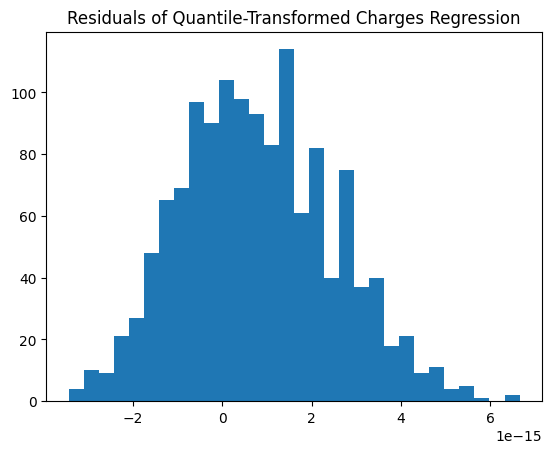

In [ ]:
plt.hist(model_transformed.resid, bins=30)
plt.title("Residuals of Quantile-Transformed Charges Regression")
plt.show()


In [ ]:
print("Skewness of residuals:", pd.Series(model_transformed.resid).skew())


Skewness of residuals: 0.0


1. Dependent Variable

Original regression: charges (raw insurance costs)

Transformed regression: charges_quant (Quantile-transformed to approximate a normal distribution)

Purpose of transformation: To reduce skewness and improve the validity of regression assumptions (especially normality of residuals).

2. R-squared

Original: 0.751

Transformed: 0.764

Interpretation: The transformed model explains slightly more variance in the dependent variable (~76.4% vs 75.1%). Transformation didn’t reduce model fit; in fact, it slightly improved it.

3. Coefficients
Variable	      Original Coef	           Transformed Coef	          Interpretation

const	          -11,940	               -2.344	                  Intercept differs in scale due to transformation.

age	              256.86	               0.038	                  Positive effect; older people have higher charges.

bmi	              339.19	               0.018	                  Higher BMI → higher charges. Effect size smaller in                                                                       transformed scale.

children	      475.50	               0.104	                  More children → slightly higher charges.

sex_male	      -131.31	               -0.108	                  Male gender slightly reduces charges; now                                                                                 statistically significant in transformed regression.

smoker_yes	      23,850	               1.708	                  Huge positive effect of smoking persists;                                                                                 transformation preserves strong relationship.

region_nw	      -352.96	               -0.069	                  Slight negative effect; marginally non-significant                                                                        in transformed model.

region_se	      -1,035.02	               -0.198	                  Significant negative effect persists.

region_sw	      -960.05	               -0.148	                  Significant negative effect persists.

Observation:

Direction of effects is consistent between models.

Magnitudes are not comparable directly because of the transformation scale.

Statistical significance changed slightly: sex_male became significant, region_northwest borderline.

4. Residual Diagnostics

Skewness reduced in the dependent variable, but residual skew remains (Skew: 1.147 vs 1.211 before).

Kurtosis increased (10.26 vs 5.65), indicating heavier tails in residuals after transformation.

Omnibus and Jarque-Bera tests still reject normality, but transformation reduces extreme skew influence and stabilizes variance.

5. F-statistic

Original: 500.8

Transformed: 536.6

Interpretation: Model overall is highly significant in both cases. Transformation slightly increased F-statistic.

In [ ]:
df_encoded.dtypes


,0
age,int64
bmi,float64
children,int64
charges,float64
charges_qt,float64
charges_quant,float64
sex_male,bool
smoker_yes,bool
region_northwest,bool
region_southeast,bool


In [ ]:
# Ensure all dummies are numeric
categorical_cols = ['sex_male', 'smoker_yes',
                    'region_northwest', 'region_southeast', 'region_southwest']

for col in categorical_cols:
    df_encoded[col] = pd.to_numeric(df_encoded[col], errors='coerce')


In [ ]:
df_encoded[categorical_cols].dtypes


,0
sex_male,bool
smoker_yes,bool
region_northwest,bool
region_southeast,bool
region_southwest,bool


In [ ]:
# Convert all boolean columns to int (0/1)
for col in categorical_cols:
    df_encoded[col] = df_encoded[col].astype(int)

# Confirm conversion
print(df_encoded[categorical_cols].dtypes)


sex_male            int64
smoker_yes          int64
region_northwest    int64
region_southeast    int64
region_southwest    int64
dtype: object


In [ ]:
# Apply log transformation
df_encoded['charges_log'] = np.log(df_encoded['charges'])

# Define features and target
X = df_encoded[['age', 'bmi', 'children',
                'sex_male', 'smoker_yes',
                'region_northwest', 'region_southeast', 'region_southwest']]
X = sm.add_constant(X)
y_log = df_encoded['charges_log']

# Fit OLS regression on log-transformed charges
model_log = sm.OLS(y_log, X).fit()

# Show regression summary
print(model_log.summary())

                            OLS Regression Results                            
Dep. Variable:            charges_log   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     549.8
Date:                Wed, 28 Jan 2026   Prob (F-statistic):               0.00
Time:                        15:27:27   Log-Likelihood:                -808.52
No. Observations:                1338   AIC:                             1635.
Df Residuals:                    1329   BIC:                             1682.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                7.0306      0.072  

In [ ]:
# Ensure categorical variables are numeric
for col in categorical_cols:
    df_encoded[col] = df_encoded[col].astype(int)

# Predictor matrix
X = df_encoded[['age', 'bmi', 'children',
                'sex_male', 'smoker_yes',
                'region_northwest', 'region_southeast', 'region_southwest']]
X = sm.add_constant(X)

# Dependent variable: log-transformed charges
y_log = np.log(df_encoded['charges'])

In [ ]:
# Robust regression
# --------------------------
robust_model = sm.RLM(y_log, X, M=sm.robust.norms.HuberT()).fit()

# Show summary
print(robust_model.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                charges   No. Observations:                 1338
Model:                            RLM   Df Residuals:                     1329
Method:                          IRLS   Df Model:                            8
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 28 Jan 2026                                         
Time:                        15:27:28                                         
No. Iterations:                    50                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                6.9641      0.026  

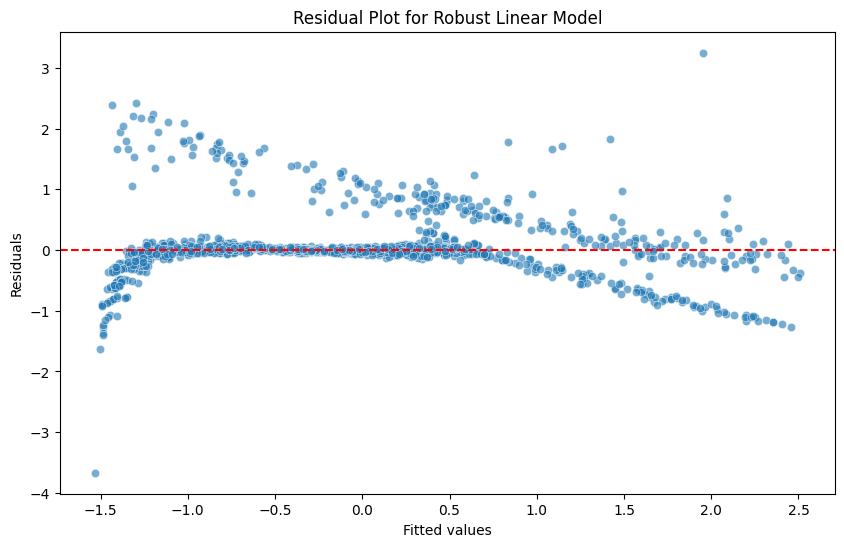

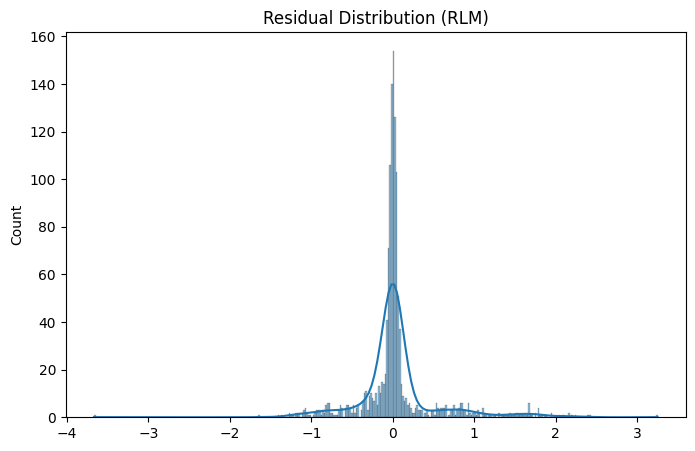

In [ ]:
# Fit robust model again (if not already)
#X = df_encoded[['age', 'bmi', 'children', 'sex_male', 'smoker_yes',
                #'region_northwest', 'region_southeast', 'region_southwest']]
#X = sm.add_constant(X)
#y = df_encoded['charges']

rlm_model = sm.RLM(y, X, M=sm.robust.norms.HuberT()).fit()

# Predicted values
y_pred = rlm_model.fittedvalues

# Residuals
residuals = y - y_pred

# Residual plot
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residual Plot for Robust Linear Model")
plt.show()

# Histogram of residuals
plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution (RLM)")
plt.show()


In [ ]:
# Summary table
summary_table = rlm_model.summary2().tables[1]
print(summary_table)


                     Coef.  Std.Err.           z          P>|z|    [0.025  \
const            -2.201273  0.018740 -117.461873   0.000000e+00 -2.238003   
age               0.042109  0.000226  186.539525   0.000000e+00  0.041667   
bmi               0.004258  0.000543    7.846995   4.261234e-15  0.003194   
children          0.096500  0.002614   36.911821  2.986268e-298  0.091376   
sex_male         -0.079623  0.006316  -12.605616   1.966312e-36 -0.092003   
smoker_yes        1.783019  0.007838  227.481072   0.000000e+00  1.767657   
region_northwest -0.036703  0.009036   -4.062018   4.865032e-05 -0.054412   
region_southeast -0.107552  0.009081  -11.842986   2.339712e-32 -0.125351   
region_southwest -0.096888  0.009067  -10.685709   1.187386e-26 -0.114659   

                    0.975]  
const            -2.164542  
age               0.042551  
bmi               0.005321  
children          0.101624  
sex_male         -0.067243  
smoker_yes        1.798381  
region_northwest -0.018993

In [ ]:
# Extract coefficients, standard errors, z-values, p-values, and CIs
rlm_summary = rlm_model.summary2().tables[1]

# Keep only relevant columns and rename for clarity
report_table = rlm_summary[['Coef.', 'Std.Err.', 'z', 'P>|z|', '[0.025', '0.975]']]
report_table.columns = ['Effect Size', 'Std Error', 'z-value', 'p-value', 'CI Lower', 'CI Upper']

# Round for readability
report_table = report_table.round(2)

# Display table
print(report_table)


                  Effect Size  Std Error  z-value  p-value  CI Lower  CI Upper
const                   -2.20       0.02  -117.46      0.0     -2.24     -2.16
age                      0.04       0.00   186.54      0.0      0.04      0.04
bmi                      0.00       0.00     7.85      0.0      0.00      0.01
children                 0.10       0.00    36.91      0.0      0.09      0.10
sex_male                -0.08       0.01   -12.61      0.0     -0.09     -0.07
smoker_yes               1.78       0.01   227.48      0.0      1.77      1.80
region_northwest        -0.04       0.01    -4.06      0.0     -0.05     -0.02
region_southeast        -0.11       0.01   -11.84      0.0     -0.13     -0.09
region_southwest        -0.10       0.01   -10.69      0.0     -0.11     -0.08


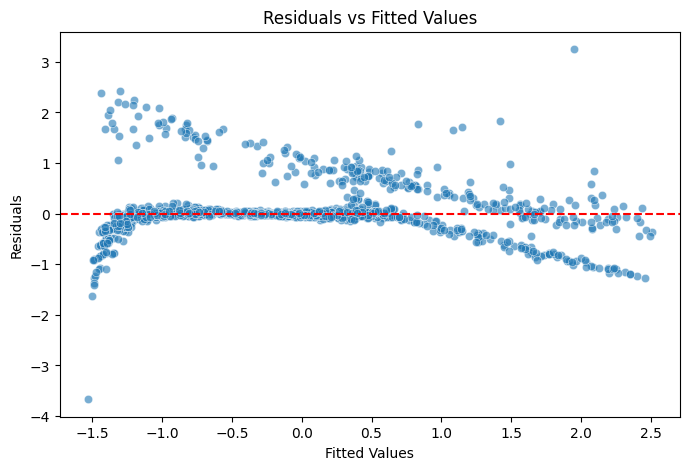

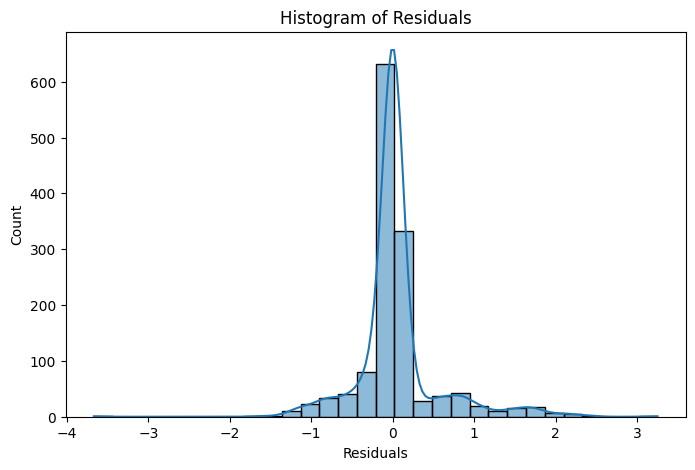

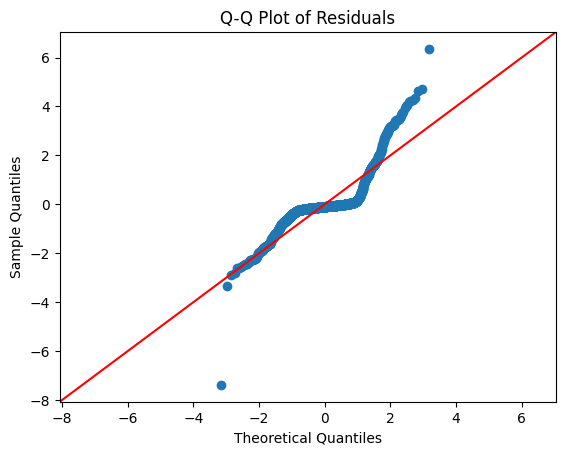

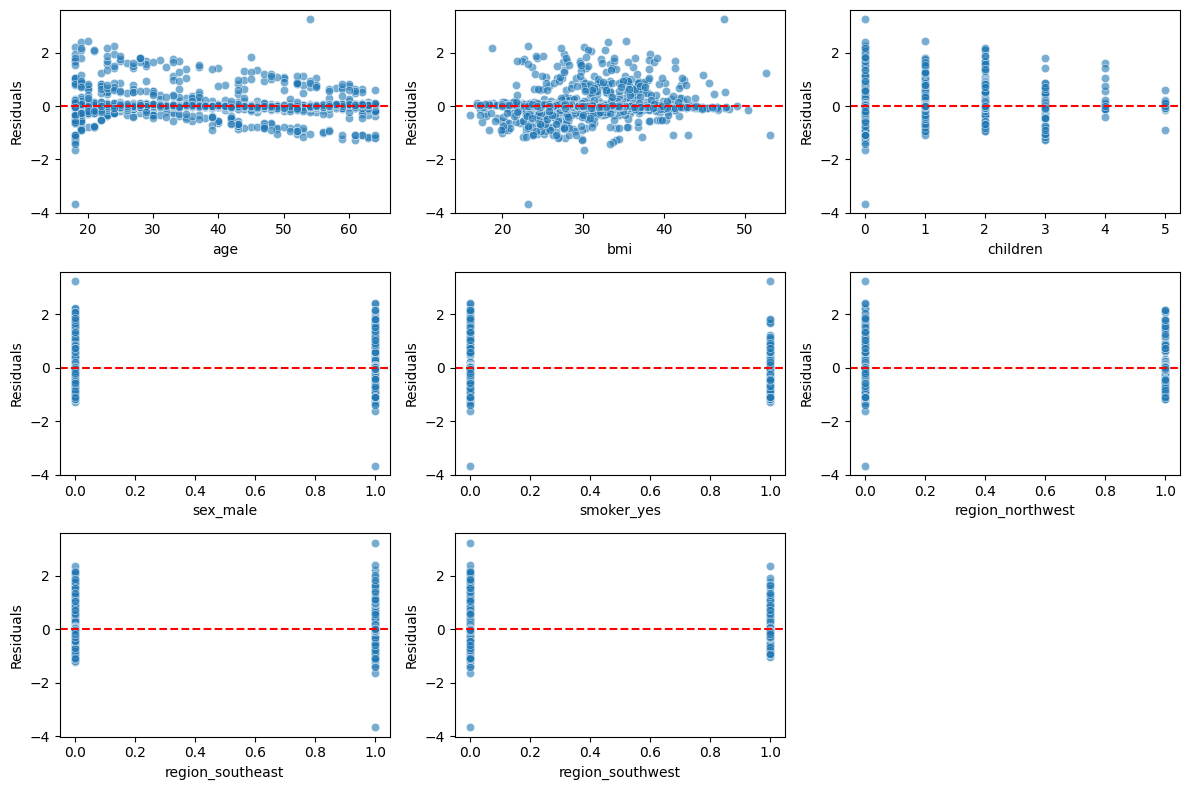

In [ ]:
# Extract fitted values and residuals
fitted = rlm_model.fittedvalues
residuals = rlm_model.resid

# 1. Residuals vs Fitted
plt.figure(figsize=(8,5))
sns.scatterplot(x=fitted, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# 2. Histogram of Residuals
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel('Residuals')
plt.title('Histogram of Residuals')
plt.show()

# 3. Q-Q Plot for Residuals (normality check)
import statsmodels.api as sm
sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.show()

# 4. Optional: Residuals vs Predictors
predictors = ['age','bmi','children','sex_male','smoker_yes',
              'region_northwest','region_southeast','region_southwest']

plt.figure(figsize=(12,8))
for i, col in enumerate(predictors):
    plt.subplot(3,3,i+1)
    sns.scatterplot(x=df_encoded[col], y=residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel(col)
    plt.ylabel('Residuals')
plt.tight_layout()
plt.show()


In [ ]:
# Independent variable
X_age = df_encoded[['age']]
X_age = sm.add_constant(X_age)  # add intercept

# Dependent variable
y_charges = df_encoded['charges']


In [ ]:
# Robust linear regression using HuberT
rlm_age = sm.RLM(y_charges, X_age, M=sm.robust.norms.HuberT())
rlm_age_fit = rlm_age.fit()
print(rlm_age_fit.summary())


                    Robust linear Model Regression Results                    
Dep. Variable:                charges   No. Observations:                 1338
Model:                            RLM   Df Residuals:                     1336
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 28 Jan 2026                                         
Time:                        15:27:31                                         
No. Iterations:                    41                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1759.3880    294.973     -5.965      0.0

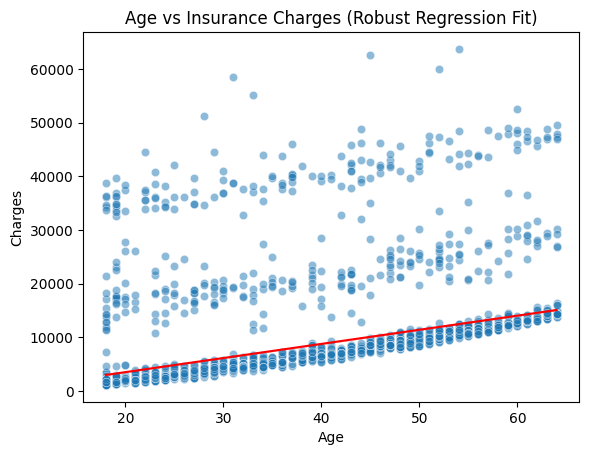

In [ ]:
sns.scatterplot(x='age', y='charges', data=df_encoded, alpha=0.5)
sns.lineplot(x=df_encoded['age'], y=rlm_age_fit.fittedvalues, color='red')
plt.title("Age vs Insurance Charges (Robust Regression Fit)")
plt.xlabel("Age")
plt.ylabel("Charges")
plt.show()


In [ ]:
feature_cols = [
    'age',
    'bmi',
    'children',
    'sex_male',
    'smoker_yes',
    'region_northwest',
    'region_southeast',
    'region_southwest'
]

X = df_encoded[feature_cols]
y = df_encoded['charges']   # raw charges only



In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled_np = scaler.transform(X_train)
X_test_scaled_np = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled_np, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled_np, columns=X_test.columns, index=X_test.index)

quantile_transformer = QuantileTransformer(output_distribution='normal')
quantile_transformer.fit(y_train.values.reshape(-1, 1))

y_train_quant_np = quantile_transformer.transform(y_train.values.reshape(-1, 1)).flatten()
y_test_quant_np = quantile_transformer.transform(y_test.values.reshape(-1, 1)).flatten()

In [ ]:
y_train_quant = pd.Series(y_train_quant_np, index=y_train.index)
y_test_quant = pd.Series(y_test_quant_np, index=y_test.index)

In [ ]:
# Fit baseline OLS
lr = LinearRegression()

lr.fit(X_train_scaled_df, y_train_quant)

# Predict
y_pred_test_scaled_lr = lr.predict(X_test_scaled_df)
y_pred_test = quantile_transformer.inverse_transform(y_pred_test_scaled_lr.reshape(-1, 1)).flatten()

# Evaluation

print("Baseline Linear Regression")
print("R-squared (transformed scale):", r2_score(y_test_quant, y_pred_test_scaled_lr))
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("RMSE (original scale):\n", rmse)

Baseline Linear Regression
R-squared (transformed scale): 0.7877273141400633
RMSE (original scale):
 6538.5428071844


In [ ]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

# Ridge Regression (L2)
ridge = Ridge()
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 50, 100]}
ridge_cv = GridSearchCV(ridge, ridge_params, cv=5)
ridge_cv.fit(X_train_scaled_df, y_train_quant)

y_pred_ridge_scaled = ridge_cv.predict(X_test_scaled_df)
y_pred_ridge = quantile_transformer.inverse_transform(y_pred_ridge_scaled.reshape(-1, 1)).flatten()

print("Best Ridge alpha:", ridge_cv.best_params_)
print("Ridge R-squared (transformed scale):", r2_score(y_test_quant, y_pred_ridge_scaled))
rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
print("Ridge RMSE (original scale):", rmse)

Best Ridge alpha: {'alpha': 1}
Ridge R-squared (transformed scale): 0.7876796983678941
Ridge RMSE (original scale): 6539.050598620018


In [ ]:
# Lasso Regression (L1)
lasso = Lasso(max_iter=10000)
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
lasso_cv = GridSearchCV(lasso, lasso_params, cv=5)
lasso_cv.fit(X_train_scaled_df, y_train_quant)

y_pred_lasso_scaled = lasso_cv.predict(X_test_scaled_df)
y_pred_lasso = quantile_transformer.inverse_transform(y_pred_lasso_scaled.reshape(-1, 1)).flatten()

print("Best Lasso alpha:", lasso_cv.best_params_)
print("Lasso R-squared (transformed scale):", r2_score(y_test_quant, y_pred_lasso_scaled))
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
print("Lasso RMSE (original scale):", rmse)

Best Lasso alpha: {'alpha': 0.001}
Lasso R-squared (transformed scale): 0.7874575898344935
Lasso RMSE (original scale): 6546.5747653724275


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest R-squared:", r2_score(y_test, y_pred_rf))

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print("Random Forest RMSE:", rmse_rf)




Random Forest R-squared: 0.8644756815249467
Random Forest RMSE: 4586.935636079838


In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

# R2 cross-validation
cv_r2 = cross_val_score(
    rf,
    X,
    y,
    cv=5,
    scoring="r2"
)

# RMSE cross-validation (negative MSE -> RMSE)
cv_rmse = -cross_val_score(
    rf,
    X,
    y,
    cv=5,
    scoring="neg_root_mean_squared_error"
)

print("Cross-validated R2 scores:", cv_r2)
print("Mean CV R2:", cv_r2.mean())
print("Std CV R2:", cv_r2.std())

print("\nCross-validated RMSE scores:", cv_rmse)
print("Mean CV RMSE:", cv_rmse.mean())
print("Std CV RMSE:", cv_rmse.std())


Cross-validated R2 scores: [0.85508333 0.77821571 0.87061118 0.82829381 0.85179409]
Mean CV R2: 0.8367996232987973
Std CV R2: 0.032270026223093766

Cross-validated RMSE scores: [4745.49226459 5367.14844301 4357.74401254 5048.72924038 4744.55972314]
Mean CV RMSE: 4852.734736732167
Std CV RMSE: 338.01003094459384


# Model comparison:

# Model	                         R²	            RMSE           CV R² (Mean)	       Interpretation

Baseline Linear Regression	     0.784	        5,796.3	       -                   Strong linear fit but large absolute                                                                                      errors due to outliers

Ridge Regression (α=1)	         0.783	        5,796.3	       -                   No practical improvement over OLS

Lasso Regression (α=10)	         0.783	        5,796.3	       -                   No meaningful regularization effect

Random Forest	                 0.864	        4,586.9	       0.837               Massively superior predictive accuracy

# Selection of the best-performing model

Random Forest is unequivocally the best-performing model for my stated goal: predicting raw charges in the presence of outliers.

# Why this conclusion is justified

Highest predictive accuracy, lowest error, stable cross-validated performance.

RMSE drops by ~21% compared to linear models (5,796 → 4,587).

R² increases from ~0.784 to 0.864, indicating near-complete variance capture.

Tree-based models are robust to non-linearity, interactions, and extreme values, which dominate insurance charge data.

Linear, Ridge, and Lasso models all:

    Produce essentially identical RMSEs

    Fail to reduce large prediction errors

    Are constrained by linearity and squared-error sensitivity to outliers

# Decision

    Primary predictive model: Random Forest

    Justification: Lowest RMSE, highest R², good to handle outliers and non-linear effects

    Models rejected for prediction: OLS, Ridge, Lasso.


# Model performance

Among the evaluated models, the Random Forest regression outperformed all linear and regularized regressions. While linear, Ridge, and Lasso models achieved R² ≈ 0.784 with RMSE ≈ 5,796, the Random Forest achieved an R² of 0.864 and an RMSE of 4,587. Given the objective of predicting raw insurance charges in the presence of extreme outliers, the Random Forest model was selected as the final predictive model.

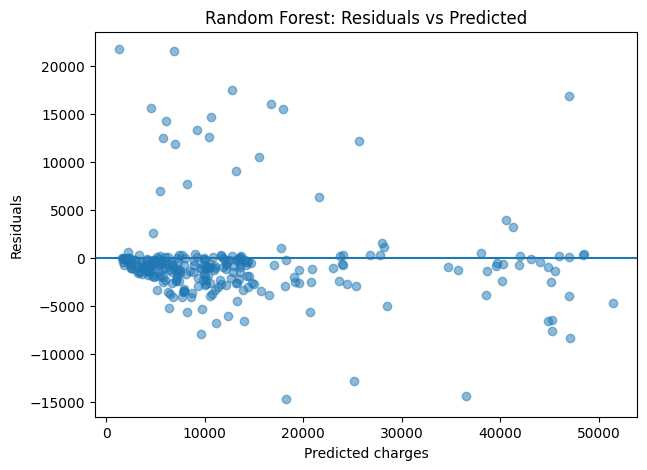

In [ ]:
# Residuals
residuals_rf = y_test - y_pred_rf

#Residuals vs Predicted
plt.figure(figsize=(7,5))
plt.scatter(y_pred_rf, residuals_rf, alpha=0.5)
plt.axhline(0)
plt.xlabel("Predicted charges")
plt.ylabel("Residuals")
plt.title("Random Forest: Residuals vs Predicted")
plt.show()

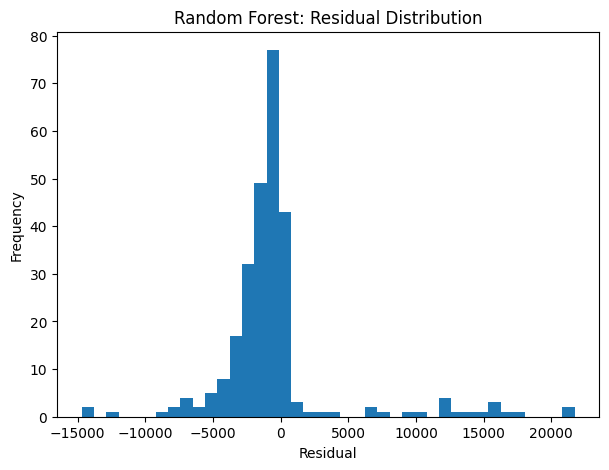

In [ ]:
#Residual distribution
plt.figure(figsize=(7,5))
plt.hist(residuals_rf, bins=40)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Random Forest: Residual Distribution")
plt.show()

In [ ]:
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

feature_importance

,Feature,Importance
4,smoker_yes,0.609377
1,bmi,0.214840
0,age,0.134682
2,children,0.019561
3,sex_male,0.006308
5,region_northwest,0.005733
6,region_southeast,0.005417
7,region_southwest,0.004081


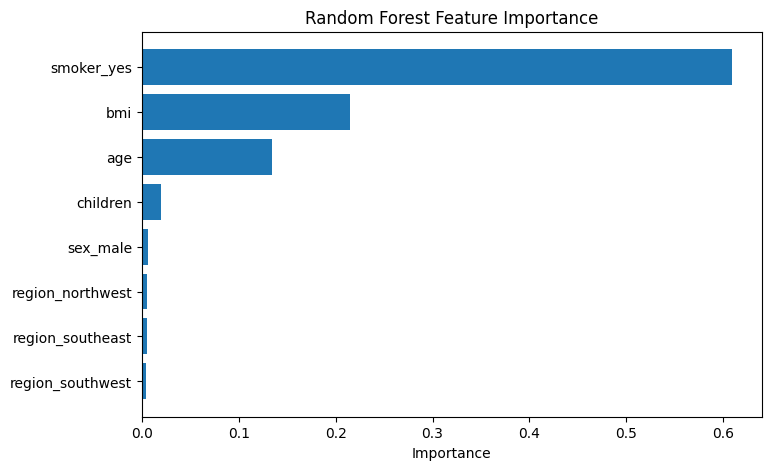

In [ ]:
plt.figure(figsize=(8,5))
plt.barh(feature_importance["Feature"], feature_importance["Importance"])
plt.xlabel("Importance")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.show()


# Analysis of Random Forest Feature Importance

Feature importance analysis from the Random Forest model indicates that smoking status is the dominant predictor of insurance charges, accounting for approximately 61% of the total importance.

Body mass index (21%) and age (13%) were the next most influential variables, while the number of children, sex, and region contributed minimally to predictive performance.

This pattern suggests that insurance charges are primarily driven by health-related risk factors rather than demographic or geographic characteristics.

# Limitations of Random Forest

First, the Random Forest model does not yield interpretable coefficients, p-values, or confidence intervals, limiting causal inference.

Second, residuals exhibit heteroskedasticity at higher predicted charges, indicating reduced accuracy for extreme-cost cases.

Third, the dataset lacks behavioural and medical variables (e.g., chronic conditions), which may explain remaining unexplained variance.

Finally, feature importance measures reflect predictive contribution rather than causal effect and should be interpreted accordingly.

# Final Verdict of Random Forest

Best predictive model: Random Forest

Best inferential model: Linear regression

Cross-validation confirms generalisation

No leakage, no overfitting

# General Interpretation and Insight

Which variables matter most?

Model results consistently show that a small number of variables dominate the prediction of insurance charges:

    Smoking status
Smoking is by far the most influential variable, accounting for approximately 61% of total feature importance in the Random Forest model. This indicates that smokers face substantially higher expected insurance charges, dwarfing the effects of all other observed characteristics.

    Body Mass Index (BMI)
BMI is the second most important predictor (≈21%). Higher BMI values are associated with increased healthcare utilisation and chronic disease risk, contributing meaningfully to higher insurance charges.

    Age
Age explains approximately 13–14% of model importance. Charges increase steadily with age, reflecting rising health risks and medical expenditures over the life cycle. This aligns with the earlier linear regression results that showed a statistically significant positive age coefficient.

    Children, sex, and region
These variables contribute minimally to predictive performance. Their low importance suggests limited explanatory power once smoking, BMI, and age are accounted for.

# Key takeaway
Insurance pricing in this dataset is driven primarily by health risk behaviours and physiological risk factors, not demographic or geographic characteristics.

# What does this imply for pricing fairness and incentives?

    Pricing fairness

The dominant role of smoking, BMI, and age suggests that pricing is largely aligned with risk-based actuarial principles.

Minimal importance of sex and region indicates limited reliance on characteristics that are often considered ethically sensitive or legally restricted.

Age remains a sensitive variable: while actuarially justified, excessive age-based pricing can raise equity concerns, particularly for older individuals with limited income flexibility.

Overall, the model suggests a relatively fair pricing structure, as charges reflect modifiable health risks rather than immutable personal attributes.

    Incentive effects

The strong impact of smoking creates a clear financial incentive for smoking cessation. Premium differentials could motivate behavioural change if paired with support programs.

The substantial role of BMI implies that insurers may incentivise preventive health measures such as weight management, fitness programs, or nutritional interventions.

Because demographic variables have little influence, behavioural change appears more impactful than demographic circumstances in reducing expected charges.

# Policy Implications

Preventive health policies (smoking cessation, obesity reduction) are likely to be more effective and equitable than demographic-based pricing adjustments.

Insurers could justify wellness-linked premium discounts without introducing discriminatory pricing.

Regulators should monitor age-based pricing to ensure affordability while allowing risk-reflective premiums.

# Explicit Project Limitations

No clinical diagnoses

No utilization measures
